In [4]:
%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable

In [40]:
from midox import midiread, midiwrite
# import pretty_midi
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink

from utils import *

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoader

In [7]:
trainset = NotesGenerationDataset('./classic/train/')

trainset_loader = Data.DataLoader(trainset, batch_size=1, shuffle=True, drop_last=True)

In [8]:
X = next(iter(trainset_loader))
X[0].shape

keys_shape = X[0].shape[2]

In [9]:
valset = NotesGenerationDataset('./classic/val/') # type: ignore

valset_loader = Data.DataLoader(valset, batch_size=1, shuffle=False, drop_last=False)

In [10]:
X_val = next(iter(valset_loader))
X_val[0].shape

torch.Size([1, 4405, 88])

# RNN

In [ ]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers = 2, is_bidirect = False):
        super(lstm_encoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.is_bidirect = is_bidirect

        self.num_directions = 2 if is_bidirect else 1

        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)

        self.lstm_layer = nn.LSTM(
            input_size = hidden_size, 
            hidden_size = hidden_size,
            num_layers = n_layers,
            batch_first = True,
            bidirectional = is_bidirect
            )   
        
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        
        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, (h_final, c_final) = self.lstm(packed, hidden)
        return h_final, c_final
    
    def init_state(self, batch_size):
        return (
            torch.zeros((self.num_directions * self.n_layers, batch_size, self.hidden_size)),
            torch.zeros((self.num_directions * self.n_layers, batch_size, self.hidden_size))
        )

In [ ]:
class lstm_decoder(nn.Module):
    def __init__(self, hidden_size, num_classes, n_layers = 2, is_bidirect = False):
        super(lstm_encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.is_bidirect = is_bidirect

        self.notes_decoder = nn.Linear(in_features=hidden_size, out_features=num_classes)

        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm_layer = nn.LSTM(
            input_size = hidden_size, 
            hidden_size = hidden_size,
            num_layers = n_layers,
            batch_first = True,
            bidirectional = is_bidirect
            )
        
    def forward(self, input, hidden_vector, encoder_cell):
        
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [12]:
model = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)

criterion = nn.CrossEntropyLoss().to(device)
criterion_val = nn.CrossEntropyLoss().to(device)

In [13]:
validate(model, valset_loader, criterion_val)

100%|██████████| 59/59 [00:06<00:00,  9.73it/s]


1.5760549373201714e-05

In [14]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [15]:
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(model.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        print('Epoch %d' % epoch_number)
        for batch in tqdm(trainset_loader):
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).to(device) )
            input_sequences_batch_var = Variable( input_sequences_batch.to(device) )

            fake = input_sequences_batch_var[:, 0:1, :]

            # plt.figure(figsize=(10,6))
            # plt.imshow(fake.cpu().numpy().reshape((fake.shape[0],88)).transpose(0,1))

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            epoch_loss.append(loss.item())
        
        print('Loss %.4f' % np.mean(epoch_loss))
    plt.plot(lrs, loss_list)
    return lrs, loss_list

Epoch 0


  0%|          | 0/177 [00:00<?, ?it/s]

100%|██████████| 177/177 [00:26<00:00,  6.69it/s]


Loss 0.3648
Epoch 1


100%|██████████| 177/177 [00:26<00:00,  6.75it/s]

Loss 17.7532


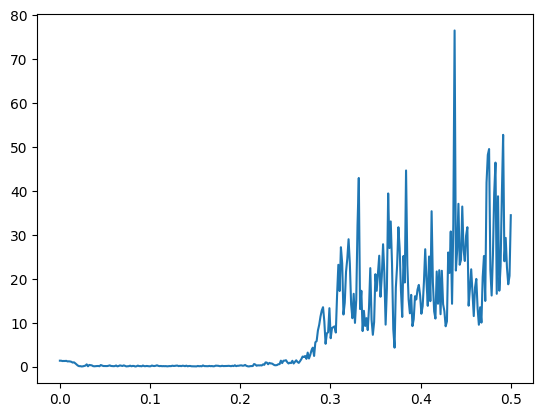

In [16]:
rnn = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)
lrs, losses = lrfinder(1e-4, 1e-1*5, rnn, trainset_loader)

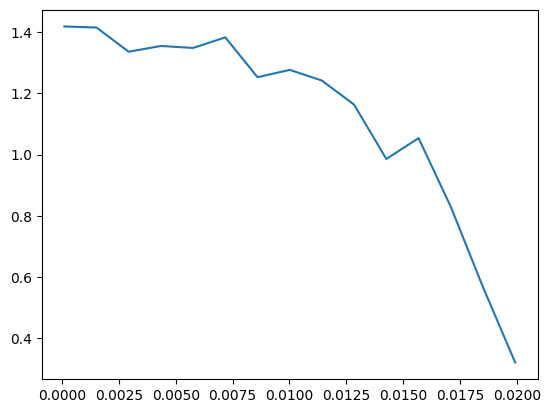

In [17]:
plt.plot(lrs[:15], losses[:15])

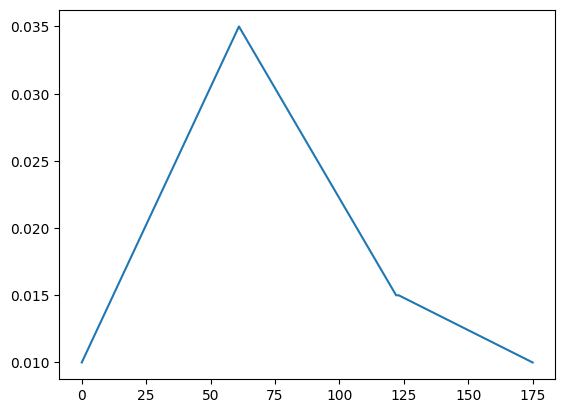

In [18]:
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
plt.plot(lrs_triangular)

In [19]:
rnn = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val)

Epoch:  0


176it [00:26,  6.61it/s]


Training Loss: Epoch: 0 : 0.22588433855670995


100%|██████████| 59/59 [00:06<00:00,  9.02it/s]


Validation Loss: Epoch: 0 : 1.679775841366846e-05

Epoch:  1


176it [00:26,  6.59it/s]


Training Loss: Epoch: 1 : 0.1525438285648486


100%|██████████| 59/59 [00:06<00:00,  8.94it/s]

Validation Loss: Epoch: 1 : 4.651087783265818e-06



In [20]:
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss)

Epoch:  0


176it [00:26,  6.58it/s]


Training Loss: Epoch: 0 : 0.14618436040851357


100%|██████████| 59/59 [00:06<00:00,  8.73it/s]


Validation Loss: Epoch: 0 : 8.926058805612241e-06

Epoch:  1


176it [00:26,  6.68it/s]


Training Loss: Epoch: 1 : 0.13816866114483042


100%|██████████| 59/59 [00:06<00:00,  8.91it/s]

Validation Loss: Epoch: 1 : 6.3974209022773175e-06



In [21]:
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss)

Epoch:  0


176it [00:26,  6.57it/s]


Training Loss: Epoch: 0 : 0.1395116661396404


100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Validation Loss: Epoch: 0 : 1.8338287990230828e-06

Epoch:  1


176it [00:27,  6.41it/s]


Training Loss: Epoch: 1 : 0.1391048864961344


100%|██████████| 59/59 [00:07<00:00,  7.78it/s]

Validation Loss: Epoch: 1 : 1.826862531479917e-06



In [34]:
rnn.load_state_dict(torch.load('music_model_padfront_regularized.pth'))

# Validation

In [23]:
def sample_from_piano_rnn(model, sample_length=4, temperature=1, starting_sequence=None):
    if starting_sequence is None:
        current_sequence_input = torch.zeros(1, 1, keys_shape)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.to(device))
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length + 10):
        output, hidden = model(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.divide(temperature), dim=1)
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
        current_sequence_input = Variable(current_sequence_input.float())
        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence[10:], dim=0).cpu().numpy()
    
    return sampled_sequence

In [24]:
testset = NotesGenerationDataset('./classic/test/')

testset_loader = Data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [25]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).to(device)

input_sequences_batch_var = input_sequences_batch.to(device)
input_sequences_batch_var.shape

torch.Size([854, 1, 88])

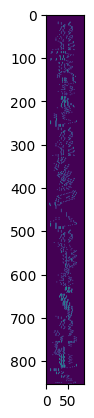

In [26]:
plt.imshow(input_sequences_batch_var.cpu().numpy().reshape((input_sequences_batch_var.shape[0],keys_shape)).transpose(0,1))

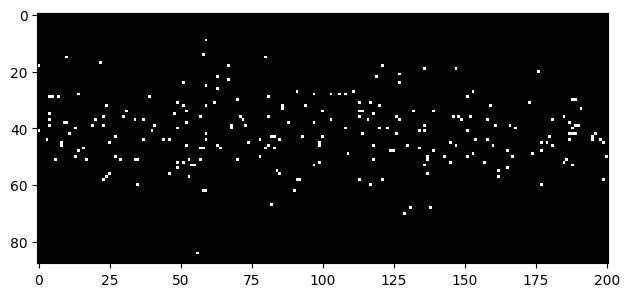

In [27]:
sample = sample_from_piano_rnn(rnn, sample_length=200, temperature=0.7, starting_sequence=X[0][:,:1,:].to(device)).transpose()
io.imshow(sample)
piano_roll = sample.transpose()

In [28]:
midiwrite('output.mid', piano_roll, dt=0.4)

# from pypianoroll import Multitrack, BinaryTrack
# piano_roll[:, 89:] = 0
# track_name = 'Piano'
# pianoroll_track = BinaryTrack(pianoroll=piano_roll, name=track_name)
# multitrack_name = 'MyMultitrack'  # Set a name for the multitrack
# multitrack = Multitrack(tracks=[pianoroll_track], name=multitrack_name, resolution=1)
# print(multitrack)
# multitrack.write('output.mid')

In [29]:
FileLink('output.mid')

/home/bhavb/Dev/SMAI/project-team-1/ckpt2/output.mid

In [30]:
# import IPython.display as ipd
# ipd.Audio('./sample_reg_018.mp3')

In [57]:
# export_onnx(rnn, 'music_model_padfront_regularized.onnx', input_shape=(8, 2, keys_shape))